In [1]:
# Step 1: Create new notebook and add the database in keggle notebook 
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/mental-cognitive-workload-eeg-data-stew-dataset/EEG data summary.pdf
/kaggle/input/mental-cognitive-workload-eeg-data-stew-dataset/three_class_one_hot.mat
/kaggle/input/mental-cognitive-workload-eeg-data-stew-dataset/dataset.mat
/kaggle/input/mental-cognitive-workload-eeg-data-stew-dataset/rating.mat
/kaggle/input/mental-cognitive-workload-eeg-data-stew-dataset/class_012.mat


In [2]:
# Step 2: Import / Load data files 
# Importing database files   
import scipy.io
dataset = scipy.io.loadmat('../input/mental-cognitive-workload-eeg-data-stew-dataset/dataset.mat')
rating = scipy.io.loadmat('../input/mental-cognitive-workload-eeg-data-stew-dataset/rating.mat')
class012 = scipy.io.loadmat('../input/mental-cognitive-workload-eeg-data-stew-dataset/class_012.mat')
class012_onehot = scipy.io.loadmat('../input/mental-cognitive-workload-eeg-data-stew-dataset/three_class_one_hot.mat')

dataset = dataset['dataset'] 
rating = rating['rating']
class012 = class012['class_012']
class012_onehot = class012_onehot['three_class_one_hot']

print(dataset.shape)
print(rating.shape)
print(class012.shape)

(14, 19200, 45)
(45, 1)
(45, 1)


In [3]:
import numpy as np

# Flatten rating to shape (45,)
ratings_flat = rating.flatten()

# Create binary class labels
class01 = np.where(np.isin(ratings_flat, [4, 5, 6]), 0,
                   np.where(np.isin(ratings_flat, [7, 8, 9]), 1, -1))

# Filter out entries with -1 (not in 4-9 range)
valid_indices = np.where(class01 != -1)[0]
class01 = class01[valid_indices]
filtered_dataset = dataset[:, :, valid_indices]  # Shape: (14, 19200, N)
filtered_rating = ratings_flat[valid_indices]

print("Filtered dataset shape:", filtered_dataset.shape)
print("Filtered class01 shape:", class01.shape)
print("Filtered ratings shape:", filtered_rating.shape)



Filtered dataset shape: (14, 19200, 45)
Filtered class01 shape: (45,)
Filtered ratings shape: (45,)


In [4]:
# Step 3: Arrange EEG data file to align with class labels
dataset.resize(45,19200,14)
print(dataset.shape)
print(class012.shape)

(45, 19200, 14)
(45, 1)


In [5]:
# Step 4: Split data into training and test set 
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(dataset, class01, test_size=0.10, random_state=42, stratify=class01)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(40, 19200, 14)
(5, 19200, 14)
(40,)
(5,)


In [6]:
# Assuming X_test is of shape (5, 19200, 14), and you want the first 64 time points
X_test_new = X_test[:, :64, :]  # Shape: (5, 64, 14)

# Extract the corresponding labels for those 5 samples
Y_test_new = Y_test[:5]  # Shape: (5,)

# Print the shapes of the new dataset
print("New X_test shape (5 samples, 14 channels, first 64 time points):", X_test_new.shape)
print("New Y_test shape (5 samples):", Y_test_new.shape)


New X_test shape (5 samples, 14 channels, first 64 time points): (5, 64, 14)
New Y_test shape (5 samples): (5,)


In [7]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, BatchNormalization, Dropout, Flatten, Dense
from tensorflow.keras.models import Model

# Step 1: Assuming `X_test_new` and `Y_test_new` are your new dataset and labels
X = X_test_new  # Shape: (5, 64, 14) or your new dataset shape
y = Y_test_new  # Corresponding binary labels (5 samples or your dataset size)

print("X shape:", X.shape)  # Should be (5, 64, 14) or your new dataset's shape
print("y shape:", y.shape)  # Should match the number of samples in X, e.g., (5,)

# Step 2: Normalize the features (z-score normalization per channel)
# Reshape to apply standardization (z-score normalization) to each channel
X_reshaped = X.reshape(-1, X.shape[2])  # Flatten across samples and channels (5 * 64, 14)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_reshaped).reshape(X.shape)  # Reshape back to (5, 64, 14)

# Step 3: Train/test split
# Since you have only 5 samples, we can use them all for training and testing
X_train = X_scaled
y_train = y
X_test = X_scaled  # You can use the same data for testing if you don't have a separate test set
y_test = y

print("Training set shape:", X_train.shape)  # (5, 64, 14)
print("Testing set shape:", X_test.shape)    # (5, 64, 14)

# Step 4: Define CNN model
input_layer = Input(shape=(64, 14))  # Adjusted for 64 time points and 14 channels (EEG data format)
x = Conv1D(filters=128, kernel_size=4, activation='relu', padding='same')(input_layer)
x = MaxPooling1D(pool_size=2)(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Conv1D(filters=64, kernel_size=8, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2)(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Adjust kernel size to avoid negative output size in the next layer
x = Conv1D(filters=32, kernel_size=4, activation='relu', padding='same')(x)
x = MaxPooling1D(pool_size=2)(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Flatten()(x)
x = Dense(100, activation='relu')(x)
output_layer = Dense(1, activation='sigmoid')(x)

model = Model(inputs=input_layer, outputs=output_layer)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# Step 5: Train the model
model.fit(X_train, y_train, epochs=10, batch_size=4, validation_data=(X_test, y_test))

# Step 6: Evaluate the model to find accuracy
loss, accuracy = model.evaluate(X_test, y_test)

# Print the results
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")


X shape: (5, 64, 14)
y shape: (5,)
Training set shape: (5, 64, 14)
Testing set shape: (5, 64, 14)


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 64, 14)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 64, 128)        │         7,296 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 32, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 32, 64)         │        65,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 16, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 16, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 16, 32)         │         8,224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_2 (MaxPooling1D)  │ (None, 8, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 8, 32)          │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 8, 32)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 100)            │        25,700 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           101 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 107,817 (421.16 KB)

 Trainable params: 107,369 (419.41 KB)

 Non-trainable params: 448 (1.75 KB)

Epoch 1/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 4s 312ms/step - accuracy: 0.5667 - loss: 0.5987 - val_accuracy: 0.4000 - val_loss: 0.6890
Epoch 2/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.8667 - loss: 0.6521 - val_accuracy: 0.6000 - val_loss: 0.6706
Epoch 3/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.2167 - loss: 1.4605 - val_accuracy: 0.6000 - val_loss: 0.6820
Epoch 4/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.2167 - loss: 1.0897 - val_accuracy: 0.4000 - val_loss: 0.7012
Epoch 5/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5667 - loss: 0.6912 - val_accuracy: 0.4000 - val_loss: 0.7170
Epoch 6/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.3500 - loss: 1.3306 - val_accuracy: 0.6000 - val_loss: 0.7114
Epoch 7/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.6500 - loss: 0.8172 - val_accuracy: 0.4000 - val_loss: 0.6922
Epoch 8/10
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - accuracy: 0.6500 - loss: 1.0498 - val_accuracy: 0.4000 - val_loss: 0.6748

In [8]:
# Assuming that the model has already been trained
# Step 6: Evaluate the model to find accuracy on the new dataset

# Ensure that the shapes of the data are correct
print("X_test shape:", X_test.shape)  # Should be (5, 64, 14)
print("y_test shape:", y_test.shape)  # Should be (5, 1)

# Evaluate the model on the test data
loss, accuracy = model.evaluate(X_test, y_test)

# Print the results
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")

# To handle more evaluation metrics like Precision, Recall, F1 Score, etc.
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, roc_auc_score

# Predict the labels on the test set
y_pred = model.predict(X_test)

# Convert predictions to binary labels (0 or 1)
y_pred_labels = (y_pred > 0.5).astype(int)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_labels)

# Calculate other evaluation metrics
precision = precision_score(y_test, y_pred_labels)
recall = recall_score(y_test, y_pred_labels)
f1 = f1_score(y_test, y_pred_labels)
roc_auc = roc_auc_score(y_test, y_pred)

# Print the additional evaluation metrics
print("Confusion Matrix:")
print(cm)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"ROC AUC: {roc_auc:.4f}")


X_test shape: (5, 64, 14)
y_test shape: (5,)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.6000 - loss: 0.6675
Test Loss: 0.6675183176994324
Test Accuracy: 0.6000000238418579
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
Confusion Matrix:
[[0 2]
 [0 3]]
Precision: 0.6000
Recall: 1.0000
F1 Score: 0.7500
ROC AUC: 0.6667


In [9]:
from sklearn.metrics import confusion_matrix

# Step 7: Confusion Matrix Evaluation of Trained Model through Test Set
# Get predictions from the model
predictions = model.predict(X_test)

# For binary classification, use a threshold of 0.5 to get class labels
Y_Predicted = (predictions > 0.5).astype(int).flatten()

# Print predicted labels
print("Predicted Labels:", Y_Predicted)

# Print actual labels
print("Actual Labels:", y_test)

# Confusion Matrix
cm = confusion_matrix(y_test, Y_Predicted)
print("Confusion Matrix:")
print(cm)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted Labels: [1 1 1 1 1]
Actual Labels: [1 0 0 1 1]
Confusion Matrix:
[[0 2]
 [0 3]]


In [10]:
print(f"Model output type: {type(model.output)}")
print(f"Model output shape: {model.output.shape}")


Model output type: <class 'keras.src.backend.common.keras_tensor.KerasTensor'>
Model output shape: (None, 1)


In [11]:
# Check the shape of X_train
print(X_train.shape)  # Should be (num_samples, input_dim), (num_samples, height, width, channels), etc.


(5, 64, 14)


Creating RawArray with float64 data, n_channels=14, n_times=64
    Range : 0 ... 63 =      0.000 ...     0.630 secs
Ready.


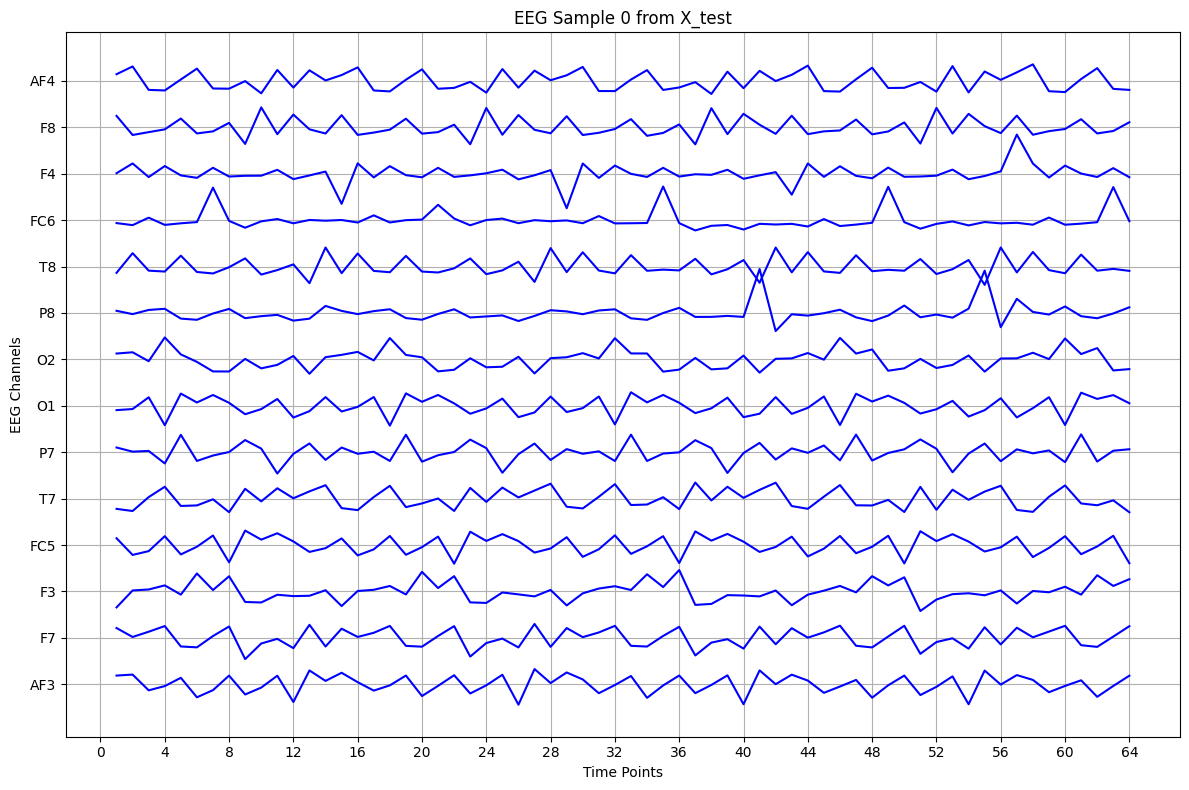

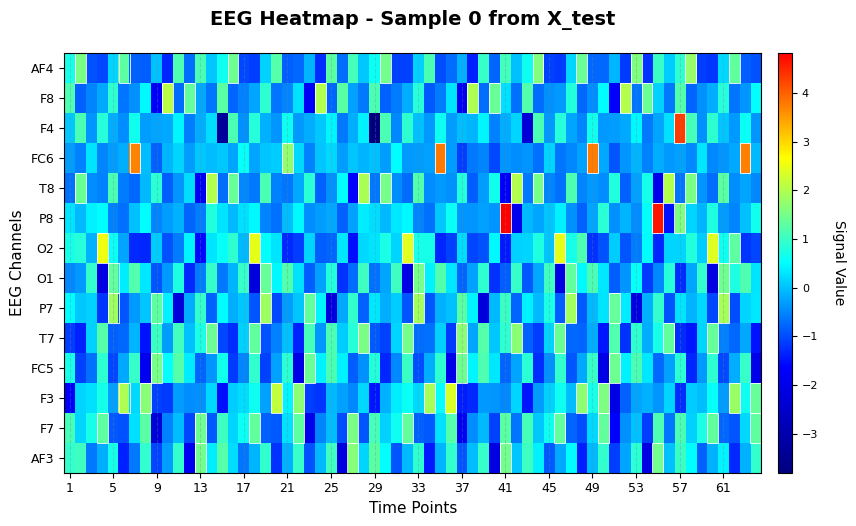

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import mne
from matplotlib.colors import LinearSegmentedColormap

# Sample index
i = 0

# Transpose from (64, 14) to (14, 64) for MNE
eeg_input = X_test[i].T  # shape: (14, 64)

# Channel names
channel_names = [
    'AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1',
    'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4'
][:eeg_input.shape[0]]

# Sampling frequency
sfreq = 100
n_channels, n_times = eeg_input.shape

# Create MNE Info object
info = mne.create_info(ch_names=channel_names, sfreq=sfreq, ch_types='eeg')

# Wrap EEG data in MNE RawArray
raw = mne.io.RawArray(eeg_input, info)

# Set a standard montage
montage = mne.channels.make_standard_montage('standard_1020')
raw.set_montage(montage, on_missing='ignore')

# ----- PLOT 1: EEG Curve -----
# Normalize each channel
normalized_eeg = (eeg_input - eeg_input.mean(axis=1, keepdims=True)) / eeg_input.std(axis=1, keepdims=True)

# Time points (1 to 64)
timepoints = np.arange(1, n_times + 1)

# Plot
plt.figure(figsize=(12, 8))
offset = 5
for idx, channel in enumerate(channel_names):
    plt.plot(timepoints, normalized_eeg[idx] + idx * offset, color='blue')  # <- changed to blue

plt.yticks(np.arange(len(channel_names)) * offset, channel_names)
plt.xticks(np.arange(0, 65, 4))  # Every 4th time point for clarity
plt.xlabel('Time Points')
plt.ylabel('EEG Channels')
plt.title(f"EEG Sample {i} from X_test")
plt.grid(True)
plt.tight_layout()
plt.show()


# ----- PLOT 2: EEG Heatmap -----
relevance_scores = eeg_input  # shape: (14, 64)

# Custom colormap
colors = [(0, 0, 0.5), (0, 0, 1), (0, 1, 1), (1, 1, 0), (1, 0, 0)]
cmap = LinearSegmentedColormap.from_list("eeg_heat", colors)

# Plot heatmap
fig, ax = plt.subplots(figsize=(12, 6))
fig.subplots_adjust(left=0.15, right=0.85, bottom=0.15, top=0.85)

im = ax.imshow(relevance_scores, cmap=cmap, aspect="auto",
               interpolation='none', origin='lower')

# Set time points on x-axis (1 to 64)
xticks = np.arange(0, 64, 4)  # every 4th time point
ax.set_xticks(xticks)
ax.set_xticklabels([str(tp + 1) for tp in xticks], fontsize=9)

# Channel labels
ax.set_yticks(np.arange(len(channel_names)))
ax.set_yticklabels(channel_names, fontsize=9)

# Colorbar
cbar = fig.colorbar(im, ax=ax, pad=0.02, aspect=30)
cbar.set_label('Signal Value', rotation=270, labelpad=20, fontsize=10)
cbar.ax.tick_params(labelsize=8)

# Titles
ax.set_title(f"EEG Heatmap - Sample {i} from X_test", fontsize=14, pad=20, weight='bold')
ax.set_xlabel("Time Points", fontsize=11)
ax.set_ylabel("EEG Channels", fontsize=11)
ax.grid(which='major', axis='x', color='gray', linestyle='--', alpha=0.3)

# Highlight top 10% values
threshold = np.percentile(relevance_scores, 90)
significant = relevance_scores > threshold

for y in range(relevance_scores.shape[0]):
    for x in range(relevance_scores.shape[1]):
        if significant[y, x]:
            ax.add_patch(plt.Rectangle((x - 0.5, y - 0.5), 1, 1,
                                       fill=False, edgecolor='white', linewidth=0.6))

plt.show()
